# Assessment of the correctness of OpenRoads network

OpenRoads network is not 100 % optimal input for morphometric analysis. This notebooks tests, whether transportation-related geometry (e.g. roundabouts) causes significant disruptions or not.

Morphometric assessment is trying to reflect the morphological structure of selected places. However, street networks often contain geometry of transport planning origin, like roundabouts, complex junctions or dual carriageways. OpenRoads network, which is used within this Urban Grammar project, is relatively clean and does include an only minimal amount of these geometries. However, there are some. Therefore, we have to first check whether we need to preprocess further and consolidate the network. In other words, we are trying to understand if the effect of sub-optimal geometry is significant or not. 

We compare results of a selection of network-based characters measured on the OpenRoads network which is preprocessed only [topologically](OpenRoads_Topology) and one the series of consolidated networks. We test a range of values for each parameter.

We first test the batch of different parameter options on the case of Liverpool (10km buffer around the centre) and then single (mid) settings on 112 UK towns and cities.

If we find that the results are significantly different between non-consolidated and consolidated options, we will fix the network before doing further analysis. If not, we will use OpenRoads network as we have it now. The deviation is considered significant if the values are more than 5% different.

In [2]:
import os

import geopandas as gpd
import pandas as pd
import numpy as np
import momepy as mm
import networkx as nx

from sqlalchemy import create_engine

from consolidate import consolidate, roundabouts, topology

Note that `consolidate` is a [custom python file](https://github.com/urbangrammarai/data_processing/blob/master/vector_data/consolidate.py) containing definitions of required functions. Even though these were originally written for this project, in future they will likely be included in the existing Python ecosystem:

- `topology` will be included in [momepy 0.4](https://github.com/martinfleis/momepy) as `remove_false_nodes`
- `consolidate` and `roundabouts` will eventually land in [OSMnx](https://github.com/gboeing/osmnx)

In [13]:
user = os.environ.get('DB_USER')
pwd = os.environ.get('DB_PWD')
host = os.environ.get('DB_HOST')
port = os.environ.get('DB_PORT')

url = f"postgres+psycopg2://{user}:{pwd}@{host}:{port}/built_env"
engine = create_engine(url)

In [3]:
x, y = 334289.32, 390468.43  # coordinates in epsg 27700
buffer = 10000  # radius in [m]

sql = f'SELECT * FROM openroads_200803 WHERE ST_DWithin(geometry, ST_SetSRID(ST_Point({x}, {y}), 27700), {buffer})'

df = gpd.read_postgis(sql, engine, geom_col='geometry')

<AxesSubplot:>

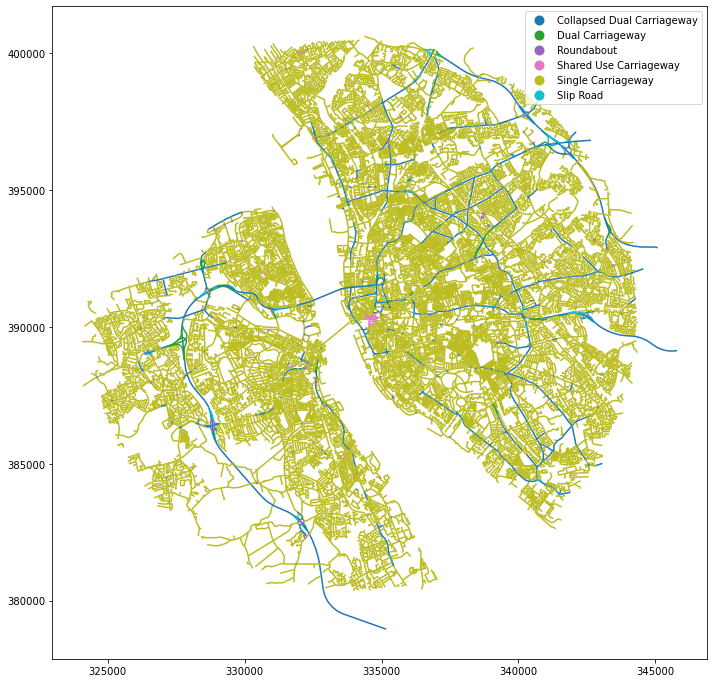

In [4]:
df.plot('formOfWay', figsize=(12, 12), legend=True)

## Topology check

Check and fix topology of the network (removal of potential nodes of degree 2).

In [5]:
topo = topology(df)

In [6]:
df.shape[0] - topo.shape[0]

1677

As we can see, the original data contain 1677 more features than topologically corrected. That indicates the overall need of topological preprocessing.

<AxesSubplot:>

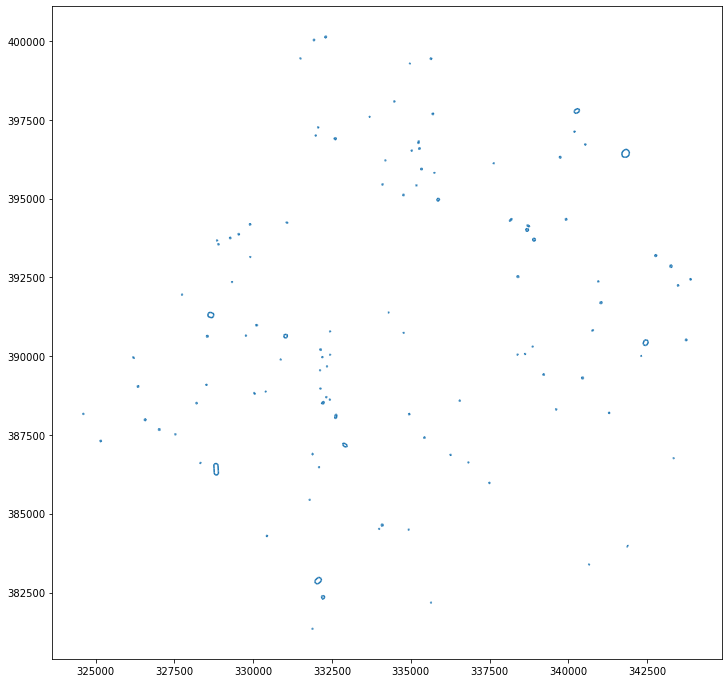

In [7]:
topo[topo.formOfWay == 'Roundabout'].plot(figsize=(12, 12))

In [8]:
(topo.formOfWay == 'Roundabout').sum()

505

505 segments marked as roundabout, where each actual roundabout is composed of ~4 segments.

In [9]:
(topo.formOfWay == 'Roundabout').sum() / topo.shape[0]

0.013554863646124115

1.3 % of all segments are marked roundabouts. Moreover, there are some other which are not explicitly marked.

## Consolidation

We will try to remove roundabouts, using `roundabouts` filter, based on a range of options. Each will be compared to the original GeoDataFrame to assess the effect on the resulting morphometric values. We will also do the visual assessment to understand the level of consolidation.

We will use `momepy` to measure node density, global meshedness, local meshedness (mean, median, std) and local closeness (mean, median, std) as characters known to be sensitive to incorrect geometry.

In [10]:
versions = {}

areas = range(500, 2501, 500)
compactness = np.linspace(0.7, 0.9, 5)

In [11]:
for area in areas:
    for comp in compactness:
        versions[(area, comp)] = consolidate(topo, filter_func=roundabouts, area=area, circom=comp)

In [12]:
comparison = pd.DataFrame(columns=['node_density', 'meshedness', 'l_mesh_mean', 'l_mesh_median', 'l_mesh_dev', 'l_close_mean', 'l_close_median', 'l_close_dev'])

In [13]:
G = mm.gdf_to_nx(topo)
comparison.loc['original', 'meshedness'] = mm.meshedness(G, radius=None)
G = mm.subgraph(G, meshedness=True, cds_length=False, mean_node_degree=False, proportion={0: False, 3: False, 4: False}, cyclomatic=False, edge_node_ratio=False, gamma=False, local_closeness=True, closeness_weight=None, verbose=True)
vals = list(nx.get_node_attributes(G, 'meshedness').values())
comparison.loc['original', 'l_mesh_mean'] = np.mean(vals)
comparison.loc['original', 'l_mesh_median'] = np.median(vals)
comparison.loc['original', 'l_mesh_dev'] = np.std(vals)
vals = list(nx.get_node_attributes(G, 'local_closeness').values())
comparison.loc['original', 'l_close_mean'] = np.mean(vals)
comparison.loc['original', 'l_close_median'] = np.median(vals)
comparison.loc['original', 'l_close_dev'] = np.std(vals)
comparison.loc['original', 'node_density'] = nx.number_of_nodes(G) / topo.length.sum()

100%|██████████| 29166/29166 [01:01<00:00, 477.43it/s]


In [14]:
for opt in versions.keys():
    G = mm.gdf_to_nx(versions[opt])
    comparison.loc[str(opt), 'meshedness'] = mm.meshedness(G, radius=None)
    G = mm.subgraph(G, meshedness=True, cds_length=False, mean_node_degree=False, proportion={0: False, 3: False, 4: False}, cyclomatic=False, edge_node_ratio=False, gamma=False, local_closeness=True, closeness_weight=None, verbose=True)
    vals = list(nx.get_node_attributes(G, 'meshedness').values())
    comparison.loc[str(opt), 'l_mesh_mean'] = np.mean(vals)
    comparison.loc[str(opt), 'l_mesh_median'] = np.median(vals)
    comparison.loc[str(opt), 'l_mesh_dev'] = np.std(vals)
    vals = list(nx.get_node_attributes(G, 'local_closeness').values())
    comparison.loc[str(opt), 'l_close_mean'] = np.mean(vals)
    comparison.loc[str(opt), 'l_close_median'] = np.median(vals)
    comparison.loc[str(opt), 'l_close_dev'] = np.std(vals)
    comparison.loc[str(opt), 'node_density'] = nx.number_of_nodes(G) / versions[opt].length.sum()

100%|██████████| 29095/29095 [01:02<00:00, 462.68it/s]


In [15]:
comparison

node_density meshedness l_mesh_mean l_mesh_median l_mesh_dev  \
original       0.00872288   0.138718   0.0936928     0.0909091  0.0598759   
(500, 0.7)     0.00871223   0.138793   0.0938334     0.0909091   0.059319   
(500, 0.75)      0.008713   0.138843   0.0938725     0.0909091  0.0593614   
(500, 0.8)     0.00871329   0.138867     0.09389     0.0917431  0.0593639   
(500, 0.85)    0.00871536   0.138898   0.0939209     0.0917431  0.0593616   
(500, 0.9)      0.0087163   0.138948   0.0939607     0.0917431  0.0593366   
(1000, 0.7)    0.00869416   0.138441   0.0935087     0.0909091  0.0592928   
(1000, 0.75)   0.00869585   0.138506   0.0935517     0.0909091  0.0593331   
(1000, 0.8)    0.00869662   0.138539   0.0935751     0.0909091  0.0593398   
(1000, 0.85)   0.00870017   0.138592   0.0936287     0.0909091  0.0593478   
(1000, 0.9)    0.00871247   0.138887    0.093857     0.0916031  0.0593428   
(1500, 0.7)    0.00868723   0.138219   0.0933306     0.0909091  0.0592881   
(1500, 0.75)   0.00868891   0.138284   0.0933737     0.0909091  0.0593286   
(1500, 0.8)    0.00868976   0.138342   0.0934093     0.0909091  0.0593372   
(1500, 0.85)   0.00869411   0.138446   0.0934853     0.0909091  0.0593332   
(1500, 0.9)     0.0087093   0.138833   0.0938105     0.0909091  0.0593394   
(2000, 0.7)    0.00868321   0.138158   0.0932909     0.0909091  0.0593087   
(2000, 0.75)    0.0086849   0.138223    0.093334     0.0909091  0.0593493   
(2000, 0.8)    0.00868575    0.13828   0.0933697     0.0909091  0.0593577   
(2000, 0.85)   0.00869009   0.138384   0.0934458     0.0909091  0.0593538   
(2000, 0.9)    0.00870625   0.138787   0.0937872     0.0909091  0.0593561   
(2500, 0.7)    0.00868074   0.138069   0.0932292     0.0909091  0.0593548   
(2500, 0.75)   0.00868243   0.138134   0.0932724     0.0909091  0.0593953   
(2500, 0.8)    0.00868328   0.138192   0.0933081     0.0909091  0.0594038   
(2500, 0.85)   0.00868864   0.138311   0.0933846     0.0909091  0.0593891   
(2500, 0.9)    0.00870479   0.138764   0.0937706     0.0909091  0.0593612   

             l_close_mean l_close_median  l_close_dev  
original      0.000311968    0.000308589  0.000126856  
(500, 0.7)    0.000312618    0.000309023  0.000127038  
(500, 0.75)   0.000312571    0.000308981  0.000127022  
(500, 0.8)    0.000312542     0.00030896   0.00012702  
(500, 0.85)   0.000312438    0.000308875  0.000126935  
(500, 0.9)    0.000312392    0.000308833  0.000126881  
(1000, 0.7)   0.000313579    0.000309811  0.000127631  
(1000, 0.75)  0.000313472    0.000309725  0.000127591  
(1000, 0.8)   0.000313421    0.000309683  0.000127576  
(1000, 0.85)  0.000313263    0.000309534  0.000127454  
(1000, 0.9)   0.000312656    0.000309002  0.000127011  
(1500, 0.7)    0.00031391    0.000310163  0.000127883  
(1500, 0.75)  0.000313803    0.000310078  0.000127842  
(1500, 0.8)   0.000313728    0.000310013  0.000127817  
(1500, 0.85)  0.000313538    0.000309821  0.000127653  
(1500, 0.9)   0.000312834    0.000309151  0.000127106  
(2000, 0.7)   0.000314062    0.000310334  0.000127971  
(2000, 0.75)  0.000313954    0.000310249  0.000127931  
(2000, 0.8)    0.00031388    0.000310184  0.000127905  
(2000, 0.85)   0.00031369    0.000309992  0.000127741  
(2000, 0.9)   0.000312952    0.000309278  0.000127168  
(2500, 0.7)   0.000314196    0.000309879  0.000128044  
(2500, 0.75)  0.000314088    0.000309793  0.000128004  
(2500, 0.8)   0.000314014    0.000309729  0.000127979  
(2500, 0.85)  0.000313799    0.000310099  0.000127792  
(2500, 0.9)   0.000313009    0.000309342  0.000127185

In [16]:
deviations = pd.DataFrame()

In [17]:
for c in comparison.columns:
    deviations[c] = (comparison.iloc[1:][c] - comparison.loc['original', c]).abs() / comparison.loc['original', c]

In [18]:
(deviations > 0.01).any()

node_density      False
meshedness        False
l_mesh_mean       False
l_mesh_median     False
l_mesh_dev        False
l_close_mean      False
l_close_median    False
l_close_dev       False
dtype: bool

In [19]:
deviations

node_density   meshedness  l_mesh_mean l_mesh_median  l_mesh_dev  \
(500, 0.7)     0.00122095  0.000541469   0.00150064             0  0.00930172   
(500, 0.75)    0.00113175  0.000899067   0.00191866             0  0.00859282   
(500, 0.8)     0.00109907   0.00107783   0.00210498    0.00917431  0.00855261   
(500, 0.85)    0.00086104    0.0012978   0.00243503    0.00917431  0.00859028   
(500, 0.9)     0.00075323   0.00165512   0.00285943    0.00917431  0.00900818   
(1000, 0.7)    0.00329184   0.00199711   0.00196469             0   0.0097388   
(1000, 0.75)   0.00309864   0.00152759   0.00150569             0  0.00906542   
(1000, 0.8)    0.00301004   0.00129292    0.0012559             0  0.00895485   
(1000, 0.85)   0.00260243  0.000906017  0.000684244             0  0.00882143   
(1000, 0.9)    0.00119321   0.00121532    0.0017532    0.00763359  0.00890449   
(1500, 0.7)    0.00408673     0.003595   0.00386553             0  0.00981802   
(1500, 0.75)    0.0038934    0.0031245   0.00340548             0  0.00914164   
(1500, 0.8)    0.00379612   0.00270972   0.00302599             0  0.00899823   
(1500, 0.85)   0.00329799   0.00196275    0.0022148             0  0.00906402   
(1500, 0.9)    0.00155686  0.000830096   0.00125639             0  0.00896027   
(2000, 0.7)    0.00454735   0.00403959   0.00428936             0   0.0094732   
(2000, 0.75)   0.00435396   0.00356871   0.00382894             0   0.0087963   
(2000, 0.8)    0.00425662   0.00315361    0.0034477             0  0.00865461   
(2000, 0.85)    0.0037584   0.00240595    0.0026358             0  0.00871978   
(2000, 0.9)    0.00190573  0.000499609   0.00100797             0  0.00868263   
(2500, 0.7)    0.00483005   0.00467772   0.00494789             0  0.00870402   
(2500, 0.75)    0.0046366   0.00420644   0.00448706             0  0.00802677   
(2500, 0.8)    0.00453921     0.003791   0.00410535             0  0.00788544   
(2500, 0.85)   0.00392472    0.0029316    0.0032894             0  0.00813084   
(2500, 0.9)    0.00207339  0.000334264  0.000831252             0  0.00859623   

             l_close_mean l_close_median  l_close_dev  
(500, 0.7)      0.0020816     0.00140777   0.00142786  
(500, 0.75)    0.00193302     0.00127026   0.00130553  
(500, 0.8)     0.00184017     0.00120151   0.00128813  
(500, 0.85)    0.00150519    0.000926625  0.000615929  
(500, 0.9)     0.00135845    0.000789239   0.00019092  
(1000, 0.7)    0.00516262     0.00395869   0.00610623  
(1000, 0.75)    0.0048192     0.00368229   0.00579156  
(1000, 0.8)    0.00465568     0.00354415   0.00567496  
(1000, 0.85)   0.00414957     0.00306094   0.00470633  
(1000, 0.9)    0.00220477     0.00133901   0.00121683  
(1500, 0.7)    0.00622365     0.00510046   0.00808836  
(1500, 0.75)   0.00587949     0.00482343   0.00777252  
(1500, 0.8)    0.00564089     0.00461576     0.007574  
(1500, 0.85)   0.00503277     0.00399325   0.00627899  
(1500, 0.9)    0.00277569     0.00182056    0.0019692  
(2000, 0.7)    0.00671031     0.00565498   0.00878297  
(2000, 0.75)   0.00636581     0.00537764   0.00846668  
(2000, 0.8)    0.00612696     0.00516974    0.0082667  
(2000, 0.85)   0.00551825     0.00454655    0.0069702  
(2000, 0.9)    0.00315204     0.00223368   0.00245444  
(2500, 0.7)    0.00714054      0.0041794   0.00936424  
(2500, 0.75)   0.00679573     0.00390233   0.00904757  
(2500, 0.8)    0.00655667     0.00369464   0.00884716  
(2500, 0.85)   0.00586718     0.00489267   0.00737622  
(2500, 0.9)    0.00333559     0.00244037   0.00258926

Based on the Liverpool case study, the negative effect of transportation-related geometry seems to be insignificant, hence the network should be only topologically corrected.

## Test across 112 UK cities

Test the significance of consolidation across samples from [112 major towns and cities](https://data.gov.uk/dataset/7879ab82-2863-401e-8a29-a56e264d2182/major-towns-and-cities-december-2015-boundaries) across UK. 

The computation is using [dask cluster](../infrastructure/dask_cluster).

We use only one option as Liverpool data showed only minimal differences between the options.

In [3]:
from dask.distributed import Client
import dask.dataframe as dd

In [4]:
client = Client("tcp://172.17.0.2:8786")

In [5]:
client

<Client: 'tcp://172.17.0.2:8786' processes=2 threads=56, memory=151.64 GB>

To make sure that our custom external scripts saved in `consolidate.py` are accessible for all workers, we have to upload it:

In [6]:
client.upload_file('consolidate.py')

Now it is safe to import the function `measure_network` which given x, y coordinates measures series of network characters within a set buffer around coordinates.

In [7]:
from consolidate import measure_network

We are using [Major Towns and Cities (December 2015) Boundaries](https://data.gov.uk/dataset/7879ab82-2863-401e-8a29-a56e264d2182/major-towns-and-cities-december-2015-boundaries) dataset by the Office for National Statistics as a pool of case studies. Sample of street network will be then defined as a buffer around a centroid of the boundary polygon.

In [8]:
cities = gpd.read_file('http://geoportal1-ons.opendata.arcgis.com/datasets/58b0dfa605d5459b80bf08082999b27c_0.geojson')
cities['geometry'] = cities.centroid.to_crs(27700)

cities = pd.DataFrame(cities.set_index('tcity15nm').geometry.apply(lambda x: (x.x, x.y)))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
cities

geometry
tcity15nm                                              
Barnsley        (434627.5156657021, 407671.86576116557)
Basildon        (570875.6914811442, 189207.87655982003)
Basingstoke     (463066.2798795874, 152019.01218638083)
Bath           (374795.29546296695, 164832.27577616548)
Bedford         (505743.6176547284, 250328.95445870835)
...                                                 ...
Woking          (500685.6824802199, 159059.72039197834)
Wolverhampton  (391271.41694731405, 299239.88030704804)
Worcester      (385584.86390267254, 255411.51403587038)
Worthing        (512797.8411381986, 103943.61490000293)
York           (459940.26973675133, 452204.59704519867)

[112 rows x 1 columns]

We then convert `pandas.DataFrame` to `dask.DataGrame` setting partitions to 25, which is less than the number of physical cores in the cluster.

Note: this specification is an intuion and other options might be more performant.

In [10]:
ddf = dd.from_pandas(cities, npartitions=25)
ddf

Dask DataFrame Structure:
               geometry
npartitions=23         
Barnsley         object
Birkenhead          ...
...                 ...
Worthing            ...
York                ...
Dask Name: from_pandas, 23 tasks

Now we apply the `measure_network` function to the dataframe to measure both consolidated and original networks. Each of the results is then stored as a parquet file on the [shared samba drive](../infrastructure/storage_drives).

In [17]:
vals_cons = ddf.apply(lambda x:  measure_network(x, user, pwd, host, port, 2500, 1000, 0.8), axis=1, meta=pd.Series(dtype='object'))

In [18]:
consolidated = vals_cons.compute()
pd.DataFrame(consolidated, columns=['values']).to_parquet('../../work/urbangrammar_samba/consolidation_comparison.pq')

In [20]:
vals_orig = ddf.apply(lambda x:  measure_network(x, user, pwd, host, port, 2500, 1000, 0.8, False), axis=1, meta=pd.Series(dtype='object'))

In [21]:
original = vals_orig.compute()
pd.DataFrame(original, columns=['values']).to_parquet('../../work/urbangrammar_samba/consolidation_original.pq')

In [29]:
consolidated

tcity15nm
Barnsley         [0.10695187165775401, 0.07840558630387251, 0.0...
Basildon         [0.066543438077634, 0.046400410869555486, 0.03...
Basingstoke      [0.08309889634278295, 0.06100586650090918, 0.0...
Bath             [0.09589993050729674, 0.06789769229755593, 0.0...
Bedford          [0.10690087829360101, 0.07504232112824535, 0.0...
                                       ...                        
Woking           [0.07844756399669695, 0.05474597309986163, 0.0...
Wolverhampton    [0.10825097678694554, 0.0738876316023328, 0.06...
Worcester        [0.08162302429818354, 0.059034771757602786, 0....
Worthing         [0.110938410724694, 0.0704577125972299, 0.0697...
York             [0.11048158640226628, 0.07967889566789936, 0.0...
Name: values, Length: 112, dtype: object

In [30]:
original

tcity15nm
Barnsley         [0.10615293886377039, 0.07754021446011636, 0.0...
Basildon         [0.06651078202130424, 0.046357524058090994, 0....
Basingstoke      [0.08338692390139335, 0.061888991203901476, 0....
Bath             [0.09524902455818224, 0.06742785926958444, 0.0...
Bedford          [0.10764315556647824, 0.07852099974944458, 0.0...
                                       ...                        
Woking           [0.07837763770896136, 0.05459775984652849, 0.0...
Wolverhampton    [0.10773418008618735, 0.07317892935647334, 0.0...
Worcester        [0.08187950686206094, 0.05932698087358212, 0.0...
Worthing         [0.11119676238196184, 0.07039460205008705, 0.0...
York             [0.10975380567562489, 0.07897317797680836, 0.0...
Name: values, Length: 112, dtype: object

To measure deviations, we convert the series of lists above to an array and calculate the deviation as an array operation.

In [31]:
cons_array = np.stack(consolidated.dropna().values)
orig_array = np.stack(original[~consolidated.isna()].values)

deviations = np.abs(cons_array - orig_array) / orig_array

Let's see if any of cities reports siginificant deviation in any of variables.

In [32]:
(deviations > 0.05).any(axis=1)

array([False, False, False, False, False, False, False, False, False,
       False, False,  True, False,  True, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False,  True, False,
        True, False, False, False, False, False,  True, False, False,
        True, False, False, False, False, False, False, False, False,
        True, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False])

In [33]:
deviated = computed.dropna()[(deviations > 0.05).any(axis=1)]
deviated.index

Index(['Bracknell', 'Brighton and Hove', 'Burton upon Trent', 'Bury',
       'Doncaster', 'Gateshead', 'Kingston upon Hull', 'Oxford', 'Plymouth',
       'Portsmouth', 'Salford', 'Shrewsbury', 'Stevenage', 'Stoke-on-Trent',
       'Wigan'],
      dtype='object', name='tcity15nm')

There are 15 towns and cities, where the difference in at least one variable is more than 5%. Let's have a look at the actual deviatoins to get a sense how much more it is.

In [34]:
deviations[(deviations > 0.05)]

array([0.06058441, 0.1058489 , 0.25531915, 0.05122838, 0.06640357,
       0.05990272, 0.08472903, 0.1155598 , 0.06998222, 0.14053365,
       0.05942378, 0.05234953, 0.10128649, 0.32063126, 0.06577461,
       0.05617978, 0.17232157, 0.06063091, 0.07765681])

Overall, there are not many deviations, so let's check the ratio of significantly deviated network variables.

In [37]:
deviations[(deviations > 0.05)].size / deviations.size

0.02445302445302445

## Conclusions

OpenRoads network certainly requires topological correction (removal of nodes of a degree 2). In terms of consolidation of transport-related geometries, the situation is more complicated. The initial study in Liverpool area suggested that the effect is not significant. However, in the test across the UK, there are some cases where at least one value is significantly affected. Based on that, we could conclude that the network requires consolidation. However, of all measured values, only 2.45% significantly deviates. Therefore, after careful consideration of options, we have decided to keep going with OpenRoads network with no consolidation. It is expected that the algorithm of identification of spatial signatures will be robust to eliminate outlying values. Moreover, the goal is to obtain a classification of the whole UK, where the overall captured deviation is insignificant.

